In [1]:
import pandas as pd
import numpy as np
import re

## Load the historical price data from CoinDesk

In [62]:
df = pd.read_csv("/Users/kyledunn/Desktop/crypto/coindesk-bpi-USD-close_data-2010-07-17_2018-06-12.csv").iloc[:-2]

In [63]:
df.tail()

,Date,Close Price
2882,2018-06-08 00:00:00,7616.10
2883,2018-06-09 00:00:00,7497.34
2884,2018-06-10 00:00:00,6765.80
2885,2018-06-11 00:00:00,6877.18
2886,2018-06-12 16:51:00,6726.51


### Split out the month-day and year elements seperately (for YoY trend comparisons)

In [64]:
def getMonthAndDay(v):
    return "{}-{}".format(v.Date[5:7], v.Date[8:10])

df['monthday'] = df.apply(getMonthAndDay, axis=1)

def getYear(v):
    return "{}".format(v.Date[0:4])

df['year'] = df.apply(getYear, axis=1)

In [65]:
df['ts'] = df.Date.map(lambda s: pd.to_datetime(s, format="%Y-%m-%d %H:%M:%S") if "-" in s else None)

In [66]:
df.tail()

,Date,Close Price,monthday,year,ts
2882,2018-06-08 00:00:00,7616.10,06-08,2018,2018-06-08 00:00:00
2883,2018-06-09 00:00:00,7497.34,06-09,2018,2018-06-09 00:00:00
2884,2018-06-10 00:00:00,6765.80,06-10,2018,2018-06-10 00:00:00
2885,2018-06-11 00:00:00,6877.18,06-11,2018,2018-06-11 00:00:00
2886,2018-06-12 16:51:00,6726.51,06-12,2018,2018-06-12 16:51:00


### Create year-over-year time series

In [67]:
yearOverYearSeries =\
df\
    .sort_values("ts", ascending=True)\
    .groupby(["year", "monthday"])['Close Price']\
    .agg(lambda df: df.reset_index(drop=True))\
    .unstack()\
    .T[:-1]

yearOverYearSeries.tail()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
monthday,,,,,,,,,
12-26,0.26,4.02,13.47,765.21,327.16,417.22,902.55,15745.26,NaN
12-27,0.26,4.07,13.42,746.72,315.17,422.52,931.11,15378.28,NaN
12-28,0.28,4.19,13.42,730.47,316.80,421.26,978.01,14428.76,NaN
12-29,0.30,4.17,13.40,745.07,312.44,432.62,969.62,14427.87,NaN
12-30,0.30,4.25,13.45,754.76,309.87,426.14,960.47,12629.81,NaN


In [143]:
%matplotlib inline

#df_p = yearOverYearSeries.drop(["This", "http"], axis=1) #.head(90)

df_norm = pd.DataFrame()
for c in yearOverYearSeries.columns:
    
    if c not in ["2013", "2014", "2017", "2018"]:
        continue
    
    maxVal = yearOverYearSeries[c].max()
    df_norm[c] = yearOverYearSeries[c].map(lambda v: v/maxVal)


### Look at different years over time

Text(0,0.5,'% max annual price')

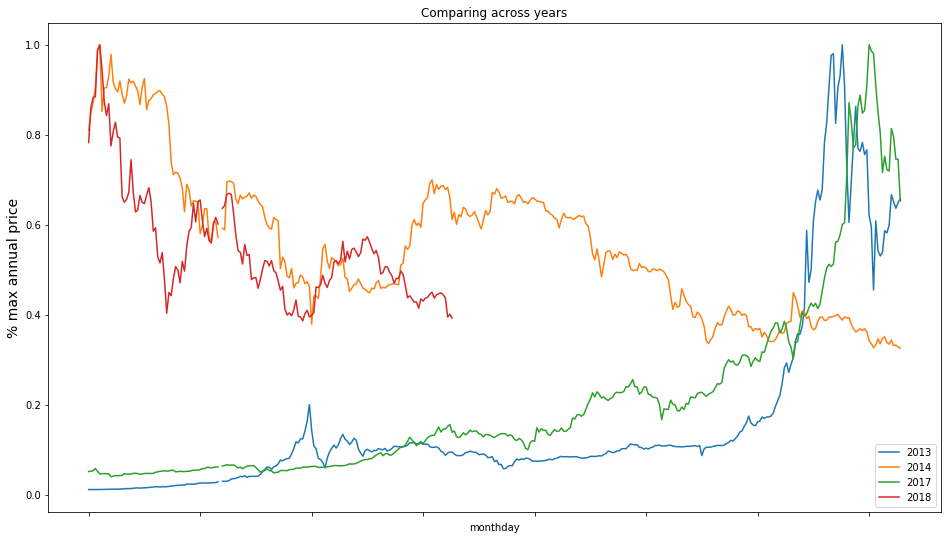

In [144]:
ax = df_norm.plot(figsize=(16, 9), title="Comparing across years")
ax.set_ylabel("% max annual price", size=14)

### Benford testing BTC & ETH for erroneous price data

In [127]:
import benford as bf
from IPython.core.display import display, HTML

# Using log-returns
def runBenford(data, columnName, confidence=[99.99999, 99.99, 99, 99, 99], force=False):
    
    tmp = data.copy()

    # Calculate simple returns
    tmp['p_r'] = tmp[columnName]/tmp[columnName].shift()-1  #simple returns

    # Calculate log-simple returns (this is what get used)
    tmp['l_r'] = np.log(tmp[columnName]/tmp[columnName].shift())  #log returns

    if tmp['l_r'].mean() < tmp['l_r'].median():
        print("Mean is less than median, try passing the force flag")
        if not force: return
    
    display(HTML('<h3>First digit test - CI: {}</h3>'.format(confidence[0])))
    f1d = bf.first_digits(tmp.l_r, digs=1, decimals=8, confidence=confidence[0])

    display(HTML('<h3>First <i>two</i> digits test - CI: {}</h3>'.format(confidence[1])))
    f2d = bf.first_digits(tmp.l_r, digs=2, decimals=8, confidence=confidence[1])

    display(HTML('<h3>First <i>three</i> digits test - CI: {}</h3>'.format(confidence[2])))
    f3d = bf.first_digits(tmp.l_r, digs=3, decimals=8, confidence=confidence[2])

    display(HTML('<h3>Second digit test - CI: {}</h3>'.format(confidence[3])))
    sd = bf.second_digit(tmp.l_r, decimals=8, confidence=confidence[3])

    display(HTML('<h3>Last two digits test - CI: {}</h3>'.format(confidence[4])))
    l2d = bf.last_two_digits(tmp.l_r, decimals=8, confidence=confidence[4])
    
# Using the pricing data directly
def runBenfordDirect(data, columnName, confidence=[99.99999, 99.99, 99, 99, 99], force=False):
    
    if data[columnName].mean() < data[columnName].median():
        print("Mean is less than median, try log-returns")
        if not force: return

    tmp = data.copy()

    display(HTML('<h3>First digit test - CI: {}</h3>'.format(confidence[0])))
    f1d = bf.first_digits(tmp[columnName], digs=1, decimals=2, confidence=confidence[0])

    display(HTML('<h3>First <i>two</i> digits test - CI: {}</h3>'.format(confidence[1])))
    f2d = bf.first_digits(tmp[columnName], digs=2, decimals=2, confidence=confidence[1])

    display(HTML('<h3>First <i>three</i> digits test - CI: {}</h3>'.format(confidence[2])))
    f3d = bf.first_digits(tmp[columnName], digs=3, decimals=2, confidence=confidence[2])

    display(HTML('<h3>Second digit test - CI: {}</h3>'.format(confidence[3])))
    sd = bf.second_digit(tmp[columnName], decimals=2, confidence=confidence[3])

    display(HTML('<h3>Last two digits test - CI: {}</h3>'.format(confidence[4])))
    l2d = bf.last_two_digits(tmp[columnName], decimals=2, confidence=confidence[4])
    

## Run Benford test for BTC, picking the _highest_ CI values which show anomolies

Initialized sequence with 2887 registries.

Test performed on 2887 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_1_Dig                              
6            0.066947  0.112574  9.771784
4            0.096910  0.135088  6.902648


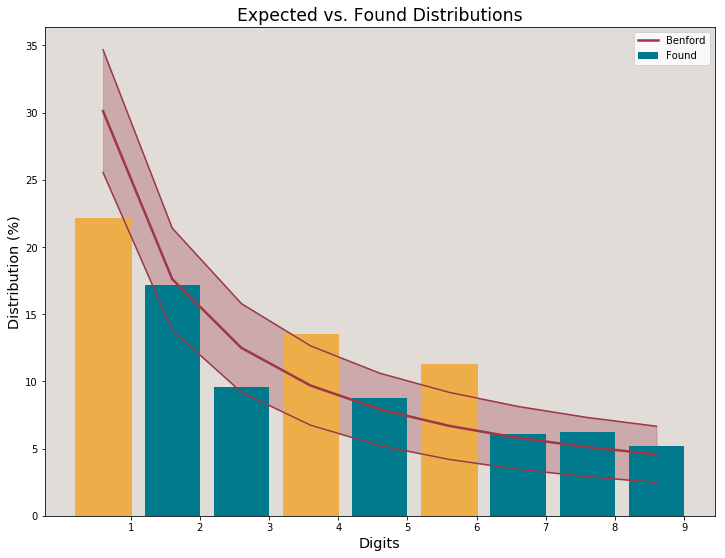

Initialized sequence with 2887 registries.

Test performed on 2887 registries.
Discarded 86 records < 10 after preparation.

The entries with the significant positive deviations are:

             Expected     Found  Z_score
First_2_Dig                             
23           0.018483  0.036773  7.11625


/Users/kyledunn/anaconda3/lib/python3.6/site-packages/benford/benford.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  int)


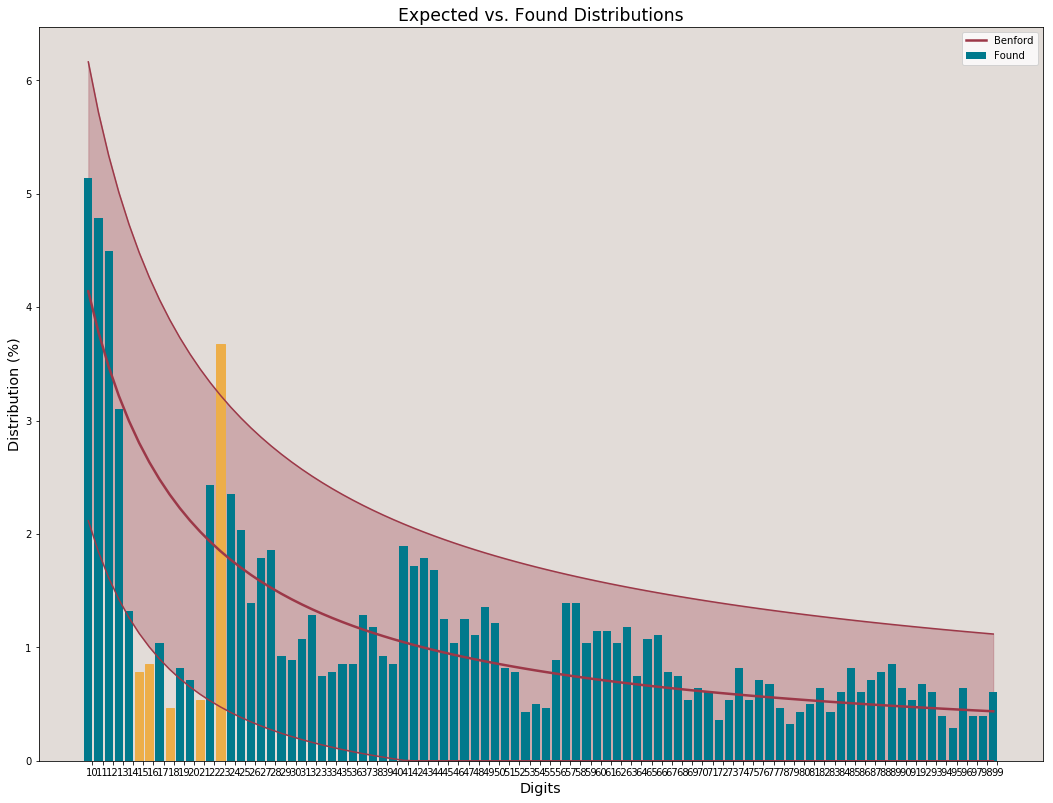

Initialized sequence with 2887 registries.

Test performed on 2887 registries.
Discarded 262 records < 100 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_3_Dig                              
608          0.000714  0.003429  4.842982
665          0.000653  0.003048  4.422929


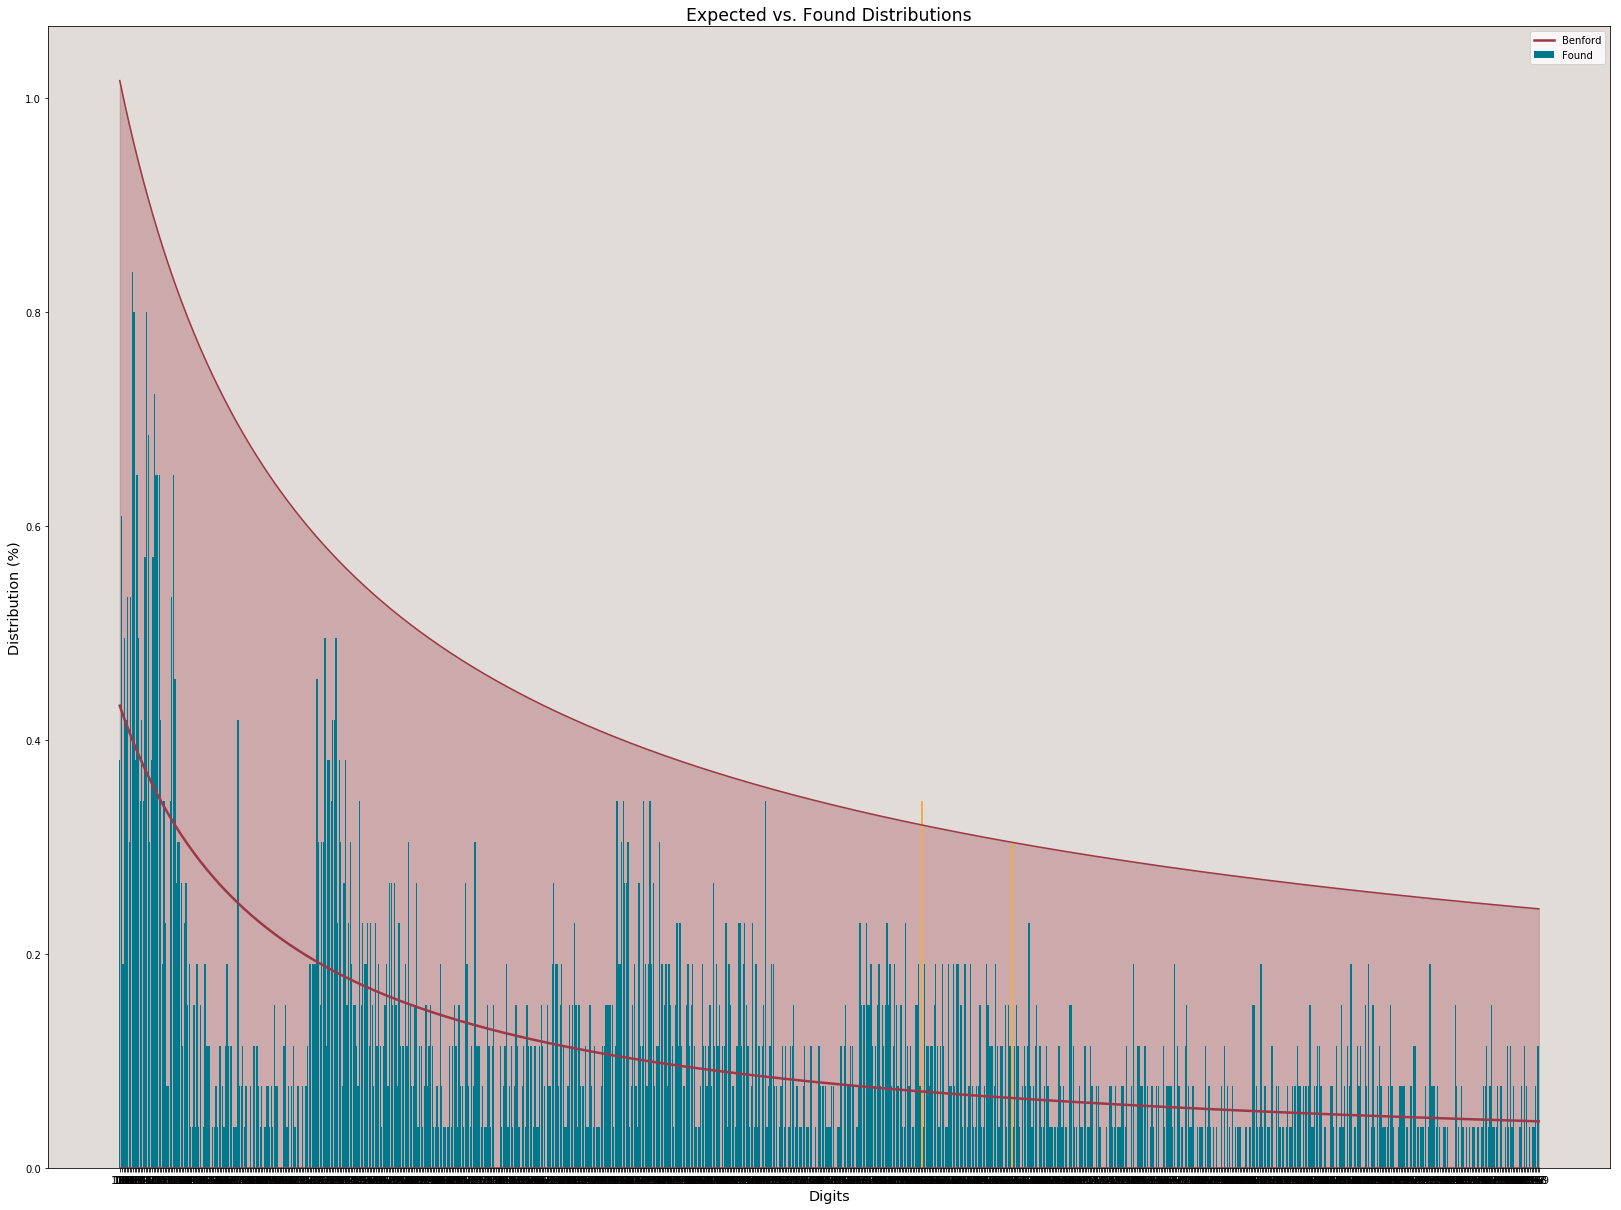

Initialized sequence with 2887 registries.

Test performed on 2801 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

         Expected     Found   Z_score
Sec_Dig                              
2        0.108821  0.134238  4.289116


/Users/kyledunn/anaconda3/lib/python3.6/site-packages/benford/benford.py:390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  int) - 1)) % 10


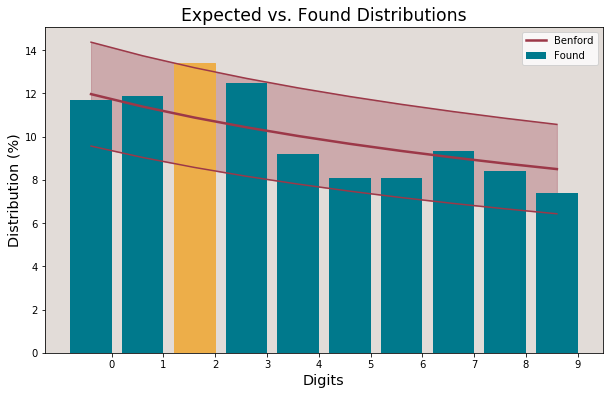

Initialized sequence with 2887 registries.

Test performed on 2887 registries.
Discarded 675 records < 1000 after preparation

The entries with the significant positive deviations are:

            Expected     Found   Z_score
Last_2_Dig                              
0           0.010101  0.018535  3.860676


/Users/kyledunn/anaconda3/lib/python3.6/site-packages/benford/benford.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp['L2D'] = temp.ZN % 100


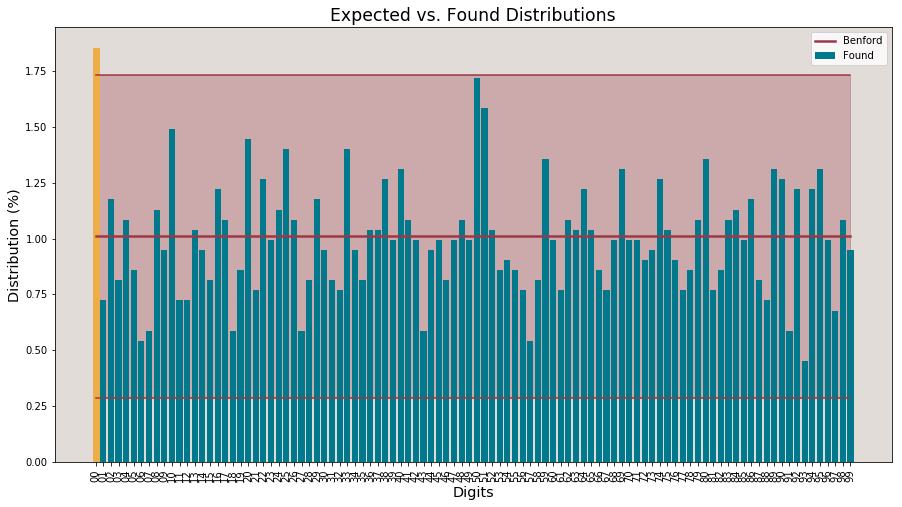

In [140]:
runBenfordDirect(df, "Close Price", confidence=[99.99999, 99.99999, 99.999, 99.99, 99.9])

In [93]:
dfe = pd.read_csv("/Users/kyledunn/Desktop/crypto/coindesk-ETH-close_data-2015-08-31_2018-06-12.csv")

## Run Benford test for ETH, picking the _highest_ CI values which show anomolies

Initialized sequence with 158 registries.

Test performed on 158 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_1_Dig                              
9            0.045757  0.101266  3.148713
8            0.051153  0.107595  3.039790


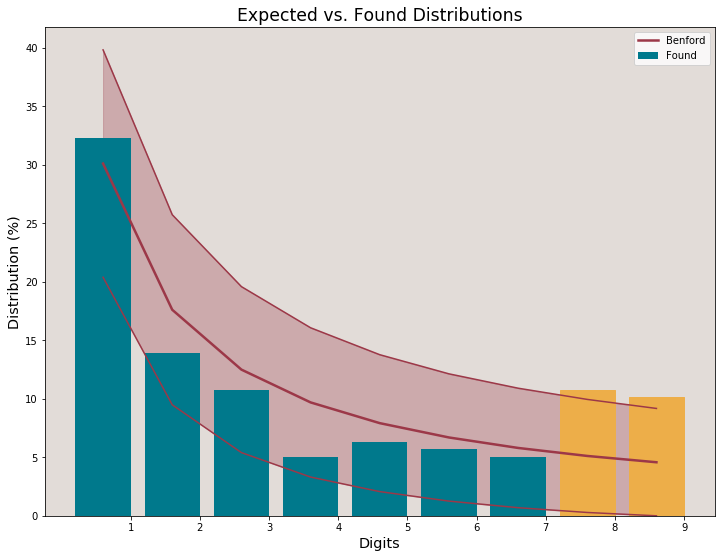

Initialized sequence with 158 registries.

Test performed on 158 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_2_Dig                              
11           0.037789  0.107595  4.392987


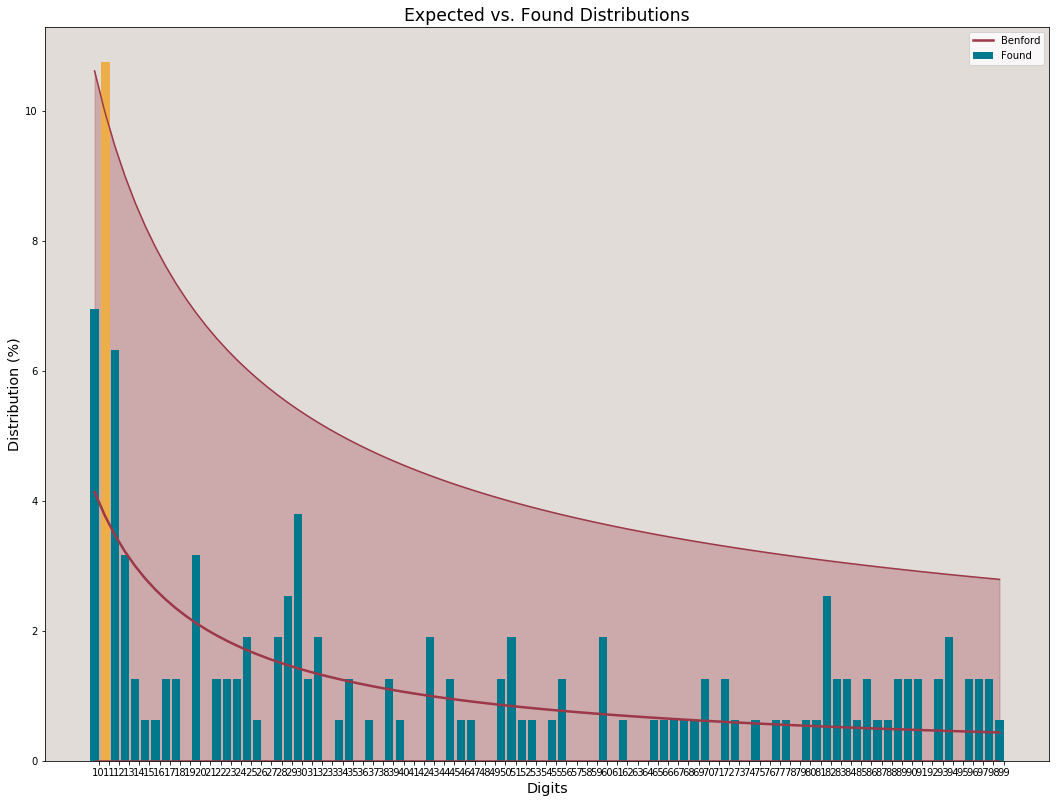

Initialized sequence with 158 registries.

Test performed on 158 registries.
Discarded 16 records < 100 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_3_Dig                              
827          0.000525  0.021127  8.887065
117          0.003696  0.035211  5.497163
839          0.000517  0.014085  5.264659


/Users/kyledunn/anaconda3/lib/python3.6/site-packages/benford/benford.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  int)


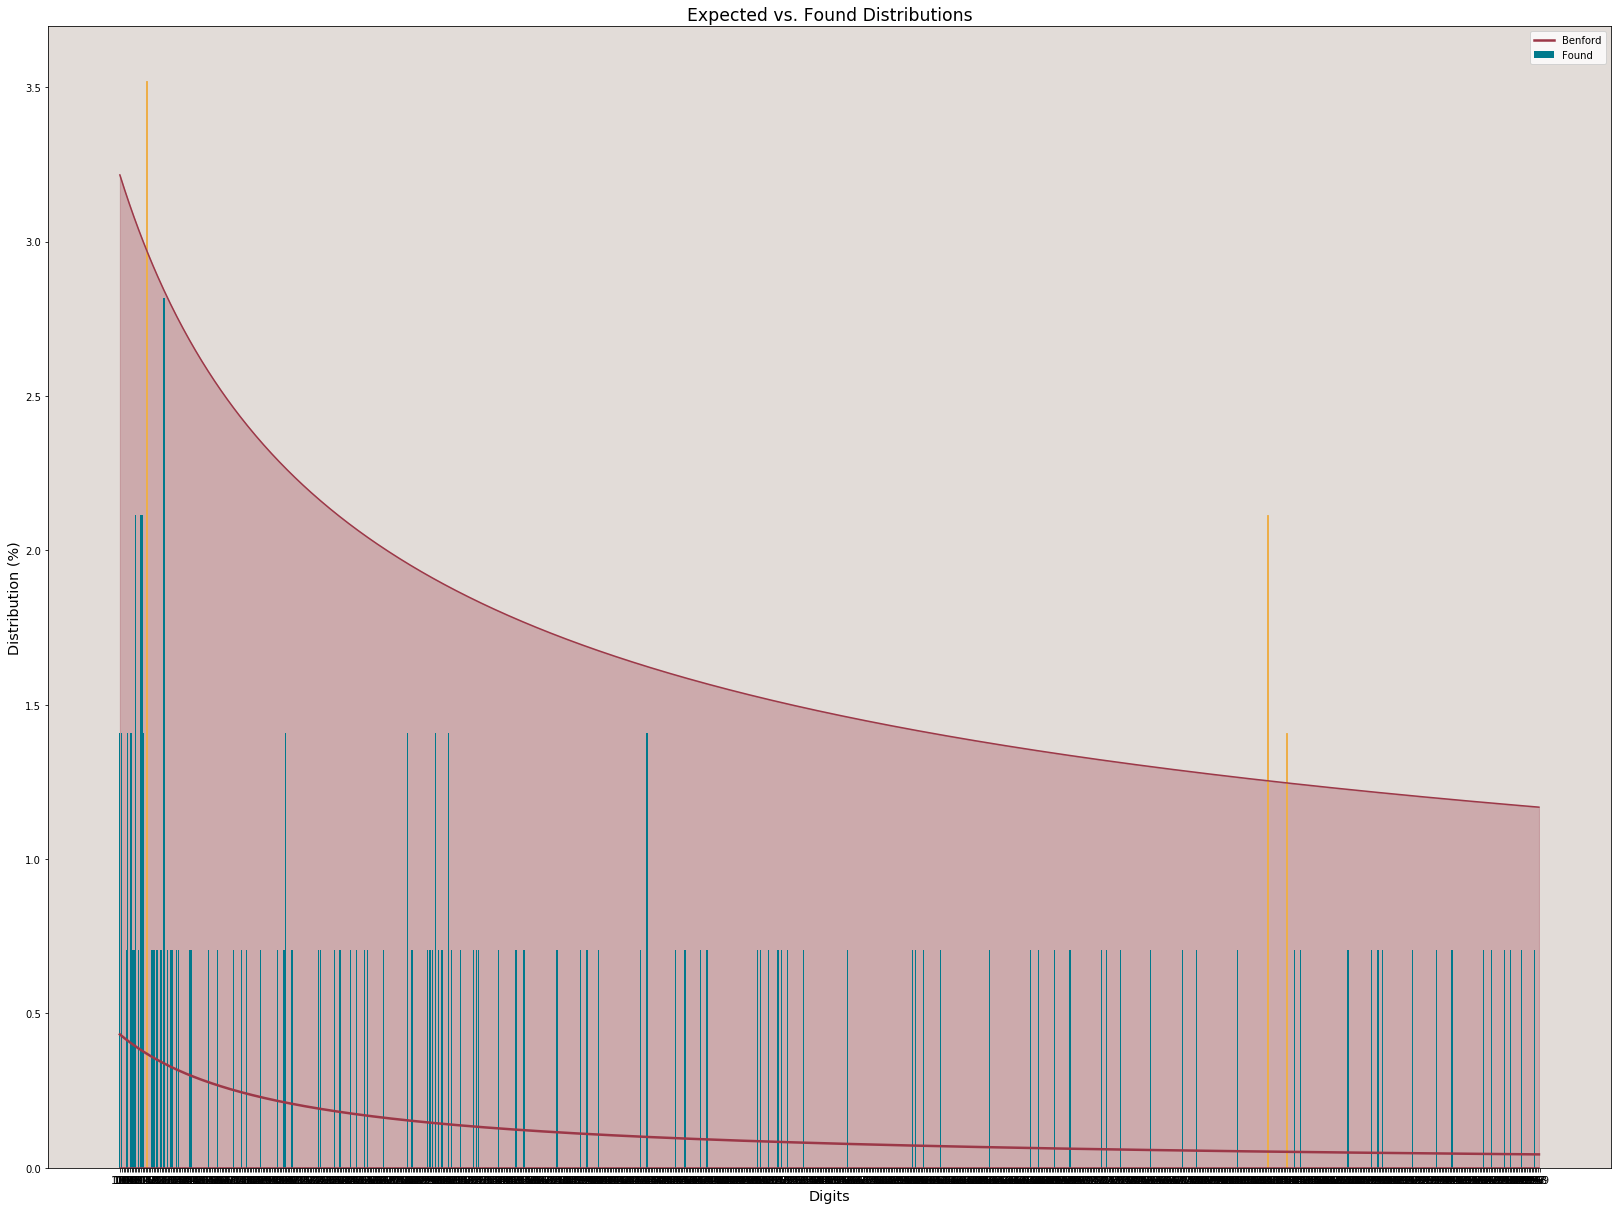

Initialized sequence with 158 registries.

Test performed on 158 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

         Expected     Found   Z_score
Sec_Dig                              
0        0.119679  0.208861  3.331061


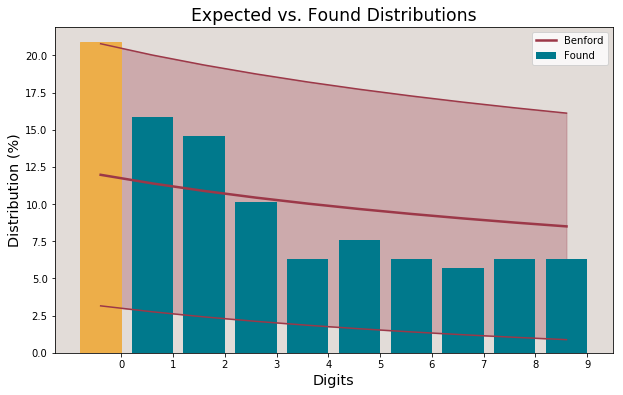

Initialized sequence with 158 registries.

Test performed on 158 registries.
Discarded 39 records < 1000 after preparation

The entries with the significant positive deviations are:

            Expected     Found   Z_score
Last_2_Dig                              
10          0.010101  0.033613  2.106662
25          0.010101  0.033613  2.106662
75          0.010101  0.033613  2.106662


/Users/kyledunn/anaconda3/lib/python3.6/site-packages/benford/benford.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp['L2D'] = temp.ZN % 100


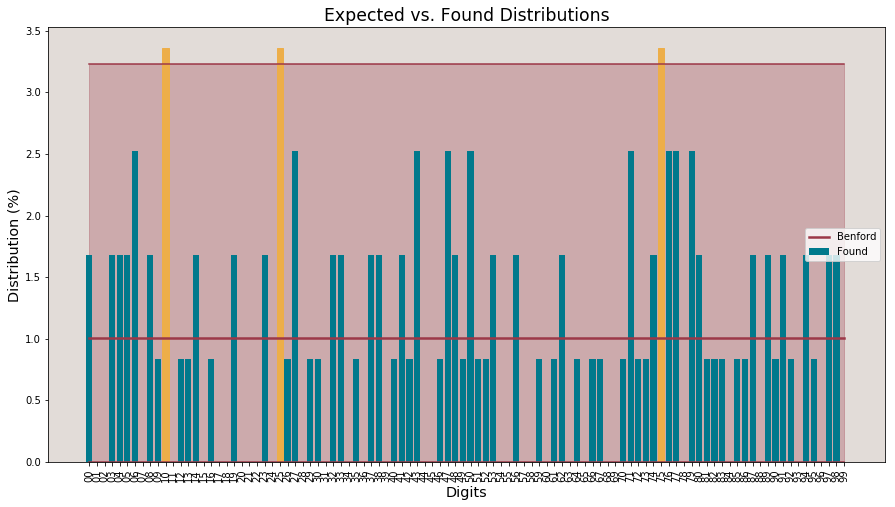

In [138]:
runBenfordDirect(dfe, "Close Price", confidence=[99, 99.99, 99.999, 99.9, 95])

### Compare BTC price and Google search interest

In [20]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

In [21]:
df_interest = pytrends.interest_over_time()

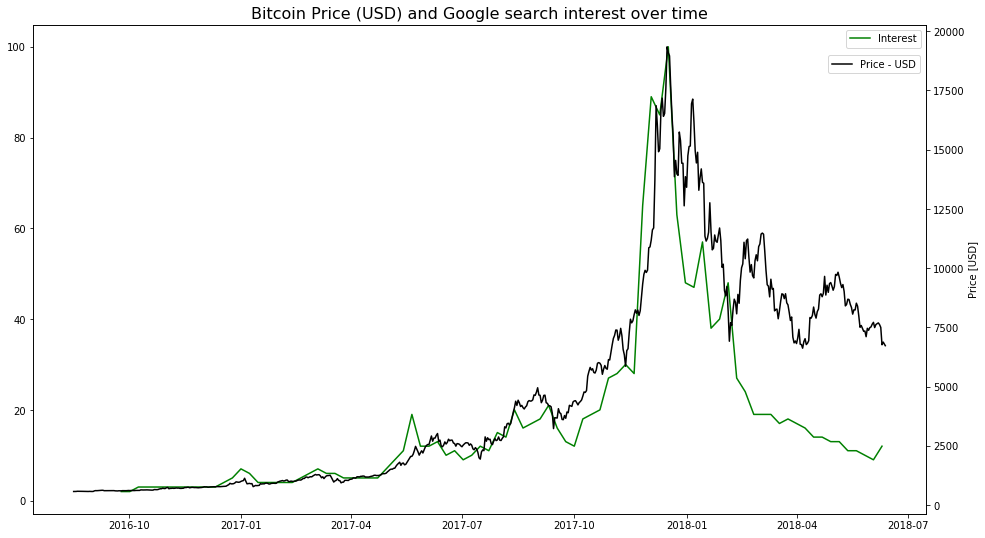

In [113]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(16, 9))
ax = f.subplots(1, 1)

ax.plot(df_interest.index[-90:], df_interest.Bitcoin[-90:], 'green', label="Interest")

ax2 = ax.twinx()

ax2.plot(df['ts'][-665:], df['Close Price'][-665:], 'black', label="Price")
ax2.set_ylabel("Price [USD]")

ax.set_title("Bitcoin Price (USD) and Google search interest over time", size=16)
ax.legend(["Interest"])
ax2.legend(["Price - USD"], loc=[0.89, 0.9])